<a href="https://colab.research.google.com/github/bigteo/BT4222_Assignment3/blob/added-insights/A3_A0203989N_tanh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BT4222 Assignment 3
By Teo Zhi Feng (A0203989N)

# 1 Setup

#### Import packages

In [1]:
import numpy as np
import tensorflow as tf

#np.random.seed(1234)
#tf.random.set_seed(1234)

In [2]:
from __future__ import print_function

from numpy.random import seed
from tensorflow.random import set_seed

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D, LSTM, MaxPooling1D, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import string
import re

#### Determine parameters

In [3]:
epochs = 10
batch_size = 128 # Select a batch size to fully utilise GPU memory, or 16 or 32

embedding_dims = 50 # emddeding for each word
maxlen = 800 # max number of words in the review

filters = 250
kernel_size = 3 # size of the 1D conv. layer
hidden_dims = 128 # number of dimensions

metrics = ['accuracy', "Precision", "Recall"]


#### Import IMDB Dataset

In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.8M      0  0:00:05  0:00:05 --:--:-- 17.2M


#### Inspect folder directory

In [5]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [6]:
!rm -r aclImdb/train/unsup

#### Import all datasets

In [7]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 157
Number of batches in raw_val_ds: 40
Number of batches in raw_test_ds: 196


#### Inspect dataset

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I gave this a four purely out of its historical context. It was considered lost for many years until it popped up out of the blue on Showtime in the early nineties.<br /><br />Moe is the straight man and Larry and Curly act as a duo. Spade Cooley has a couple of numbers. I guess it had something to do with working on a ranch. I'm not quite sure because the plot was so minimal nothing really sticks in my memory. I vaguely remember it being a western musical comedy. Even the Stooge's seem to be going through the motions. Overall there's nothing much really to recommend here.<br /><br />If you're not a Stooge fan then don't bother. If you are a Stooge fan, then stick with the shorts."
0
b'First than anything, I\'m not going to praise I\xc3\xb1arritu\'s short film, even I\'m Mexican and proud of his success in mainstream Hollywood.<br /><br />In another hand, I see most of the reviews focuses on their favorite (and not so) short films; but we are forgetting that there is a subtle bottom 

#### Define list to store model performance

In [9]:
results = {}

#### Helper function to extract results

In [10]:
def get_results(metrics):
  loss = round(metrics[0], 3)
  accuracy = round(metrics[1], 3)
  precision = round(metrics[2], 3)
  recall = round(metrics[3], 3)
  return loss, accuracy, precision, recall

# 2 Data Pre-Processing

#### Vectorise data

In [11]:
# Define custom function
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Model constants.
max_features = 20000

# Instantiate text vectorisation layer to normalize, split, and map strings to integers.
# We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=maxlen,
)

# With vocab layer, call `adapt` on a text-only dataset to create the vocabulary. 
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
print(len(vectorize_layer.get_vocabulary()))
print(vectorize_layer.get_vocabulary()[:20])

20000
['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']


In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

#### Inspect vectorised dataset

In [14]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'OK, so the musical pieces were poorly written and generally poorly sung (though Walken and Marner, particularly Walken, sounded pretty good). And so they shattered the fourth wall at the end by having the king and his nobles sing about the "battle" with the ogre, and praise the efforts of Puss in Boots when they by rights shouldn\'t have even known about it.<br /><br />Who cares? It\'s Christopher Freakin\' Walken, doing a movie based on a fairy tale, and he sings and dances. His acting style fits the role very well as the devious, mischievous Puss who seems to get his master into deeper and deeper trouble but in fact has a plan he\'s thought about seven or eight moves in advance. And if you\'ve ever seen Walken in any of his villainous roles, you *know* the ogre bit the dust HARD at the end when Walken got him into his trap.<br /><br />A fun film, and a must-see for anyone who enjoys the unique style of Christopher Walken.', shape=(), dtype=string)
Label pos
Vectori

# 3 Convolutional Neural Network (CNN)

#### Build model

In [15]:
model_cnn = Sequential()
model_cnn.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))

# Convolution and pooling layer 1
model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='tanh',
                 strides=1))
model_cnn.add(GlobalMaxPooling1D())

# Flatten before connecting to dense layer 
model_cnn.add(Flatten())

model_cnn.add(Dense(hidden_dims, activation='tanh'))
model_cnn.add(Dropout(0.5))

# Project onto a single unit, dense output layer and apply sigmoid activation function
# to make 0 or 1 predictions for the two classes (positive or negative).
model_cnn.add(Dense(1, activation='sigmoid', name='predictions'))

# Use binary_crossentropy loss function as it is a binary classification problem 
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [16]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 50)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 800, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 1

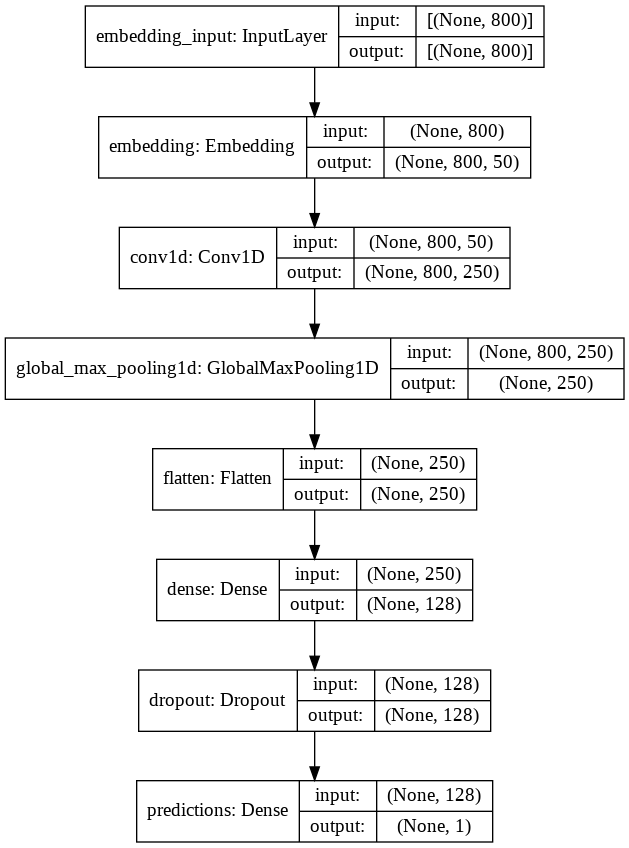

In [17]:
plot_model(model_cnn, show_shapes=True)

#### Train model using train dataset

In [18]:
# Fit model using train dataset
history_cnn = model_cnn.fit(train_ds,
              epochs=epochs,
              verbose = 1,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/10
157/157 [==============================] - 41s 66ms/step - loss: 0.5250 - accuracy: 0.7156 - precision: 0.7114 - recall: 0.7232 - val_loss: 0.3443 - val_accuracy: 0.8454 - val_precision: 0.8537 - val_recall: 0.8372
Epoch 2/10
157/157 [==============================] - 9s 57ms/step - loss: 0.2410 - accuracy: 0.9028 - precision: 0.8997 - recall: 0.9063 - val_loss: 0.2765 - val_accuracy: 0.8858 - val_precision: 0.9000 - val_recall: 0.8704
Epoch 3/10
157/157 [==============================] - 9s 57ms/step - loss: 0.1097 - accuracy: 0.9631 - precision: 0.9617 - recall: 0.9643 - val_loss: 0.2958 - val_accuracy: 0.8912 - val_precision: 0.8793 - val_recall: 0.9093
Epoch 4/10
157/157 [==============================] - 9s 57ms/step - loss: 0.0501 - accuracy: 0.9844 - precision: 0.9852 - recall: 0.9835 - val_loss: 0.6894 - val_accuracy: 0.8206 - val_precision: 0.7450 - val_recall: 0.9802
Epoch 5/10
157/157 [==============================] - 9s 57ms/step - loss: 0.0304 - accuracy: 0.990

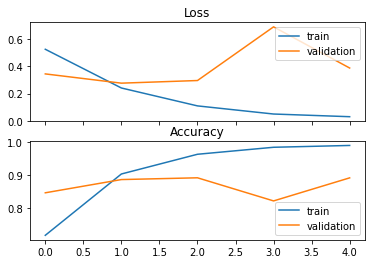

In [19]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_cnn.history['loss'], label='train')
axis[0].plot(history_cnn.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_cnn.history['accuracy'], label='train')
axis[1].plot(history_cnn.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [20]:
metrics_cnn = model_cnn.evaluate(test_ds,verbose=1)

196/196 [==============================] - 7s 33ms/step - loss: 0.4174 - accuracy: 0.8813 - precision: 0.8937 - recall: 0.8656


In [21]:
loss_cnn, accuracy_cnn, precision_cnn, recall_cnn = get_results(metrics_cnn)
print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_cnn, accuracy_cnn, precision_cnn, recall_cnn))

Model performance on test set:
Loss: 0.417
Accuracy: 0.881
Precision: 0.894
Recall: 0.866



In [22]:
results['CNN'] = {
    'Loss': loss_cnn,
    'Accuracy': accuracy_cnn,
    'Precision': precision_cnn, 
    'Recall': recall_cnn,
    'F1': round( 2*((precision_cnn * recall_cnn) / (precision_cnn + recall_cnn)), 3 )
  }

# 4 Long Short-Term Memory (LSTM) 

### Build model

In [23]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))

model_lstm.add(LSTM(120, return_sequences=True))
model_lstm.add(GlobalMaxPooling1D())

model_lstm.add(Dense(1, activation='sigmoid', name='predictions'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [24]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 50)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 800, 120)          82080     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 121       
Total params: 1,082,201
Trainable params: 1,082,201
Non-trainable params: 0
_________________________________________________________________


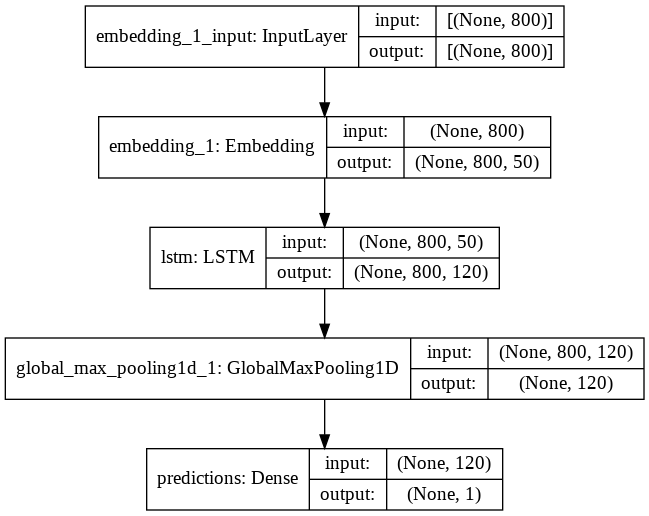

In [25]:
plot_model(model_lstm, show_shapes=True)

#### Train model using train dataset

In [26]:
# Fit model using train dataset
history_lstm = model_lstm.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/10
157/157 [==============================] - 31s 180ms/step - loss: 0.6499 - accuracy: 0.6400 - precision: 0.6362 - recall: 0.6502 - val_loss: 0.5115 - val_accuracy: 0.7676 - val_precision: 0.7679 - val_recall: 0.7734
Epoch 2/10
157/157 [==============================] - 27s 175ms/step - loss: 0.3856 - accuracy: 0.8413 - precision: 0.8560 - recall: 0.8197 - val_loss: 0.3146 - val_accuracy: 0.8644 - val_precision: 0.8470 - val_recall: 0.8926
Epoch 3/10
157/157 [==============================] - 28s 176ms/step - loss: 0.2183 - accuracy: 0.9186 - precision: 0.9177 - recall: 0.9191 - val_loss: 0.3473 - val_accuracy: 0.8590 - val_precision: 0.8139 - val_recall: 0.9342
Epoch 4/10
157/157 [==============================] - 27s 175ms/step - loss: 0.1475 - accuracy: 0.9510 - precision: 0.9504 - recall: 0.9515 - val_loss: 0.4230 - val_accuracy: 0.8644 - val_precision: 0.8306 - val_recall: 0.9188
Epoch 5/10
157/157 [==============================] - 28s 177ms/step - loss: 0.1043 - accura

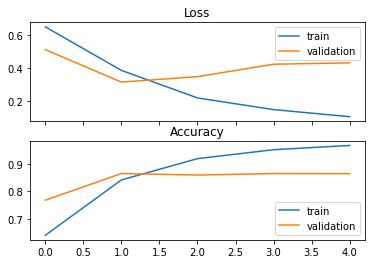

In [27]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_lstm.history['loss'], label='train')
axis[0].plot(history_lstm.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_lstm.history['accuracy'], label='train')
axis[1].plot(history_lstm.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [28]:
metrics_lstm = model_lstm.evaluate(test_ds,verbose=1)

196/196 [==============================] - 11s 55ms/step - loss: 0.5056 - accuracy: 0.8401 - precision: 0.9078 - recall: 0.7571


In [29]:
loss_lstm, accuracy_lstm, precision_lstm, recall_lstm = get_results(metrics_lstm)
print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_lstm, accuracy_lstm, precision_lstm, recall_lstm))

Model performance on test set:
Loss: 0.506
Accuracy: 0.84
Precision: 0.908
Recall: 0.757



In [30]:
results['LSTM'] = {
    'Loss': loss_lstm,
    'Accuracy': accuracy_lstm,
    'Precision': precision_lstm, 
    'Recall': recall_lstm,
    'F1': round( 2*((precision_lstm * recall_lstm) / (precision_lstm + recall_lstm)), 3 )
  }

# 5 Model Comparison
The results are summarised in the DataFrame below.

In [31]:
pd.DataFrame(results)

,CNN,LSTM
Loss,0.417,0.506
Accuracy,0.881,0.840
Precision,0.894,0.908
Recall,0.866,0.757
F1,0.880,0.826


From the results, we see that CNN performed better than LSTM, achieving a higher accuracy (0.886 vs 0.853), precision (0.885 vs 0.822), and F1 scores (0.887 vs 0.859). Recall scores are comparable for both models. 

We see that CNN performed better than LSTM. This is likely because whether a review is negative or positive can be determined by a window of local features, something that CNN can more accurately identify.

On the other hand, the sequential and hence contextual information that RNN can identify may not be as significant in this sentiment analysis. Furthermore, there is a higher risk of bias and hence overfitting when using LSTM.

Comments on CNN:
1. CNN is useful to recognise patterns across space as it extracts local and position-invariant features.
3. CNN is computationally faster as it allows for parallelization over every element in the word sequence.
4. CNN is better when feature detection in text is more important but it is difficult to obtain contextual information.

Comments on LSTM/RNN:
1. LSTM/RNN is useful to recognise patterns across time as it captures long-term dependencies between word sequences.
2. LSTM/RNN is ideal for sequential data when the current step is related with the previous steps or datasets with a time component. 
3. LSTM/RNN is better when sequential modeling is more important but the order of words can lead to bias. 

# 6 Additional Insights

#### Insight 1: Wide vs deep neural network

Deep neural network (6 layers of CNN followed by 3 fully connected layers)

In [32]:
embedding_dims = 10
# Define model
model_deep = Sequential()
model_deep.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Convolutional layer
model_deep.add(Conv1D(filters, kernel_size, padding='same', activation='tanh', strides=1))
model_deep.add(MaxPooling1D(pool_size=2))
# More convolutional layers
for i in range(3):
  model_deep.add(Conv1D(filters, kernel_size, padding='same', activation='tanh', strides=1))
  model_deep.add(MaxPooling1D(pool_size=2))
model_deep.add(Flatten())
# Fully connected layer
model_deep.add(Dense(hidden_dims, activation='tanh'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(1, activation='sigmoid', name='predictions'))
# Compile
model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [33]:
print('Total number of parameters for model_cnn: 1,070,007')
model_deep.summary()

Total number of parameters for model_cnn: 1,070,007
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 800, 10)           200000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 800, 250)          7750      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 400, 250)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 250)          187750    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 250)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 250)          187750    
_________________________________________________________________
ma

In [34]:
history_deep = model_deep.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_deep = model_deep.evaluate(test_ds,verbose=0)

Epoch 1/10
157/157 [==============================] - 24s 141ms/step - loss: 0.5050 - accuracy: 0.7209 - precision: 0.7255 - recall: 0.7085 - val_loss: 0.3079 - val_accuracy: 0.8758 - val_precision: 0.8879 - val_recall: 0.8629
Epoch 2/10
157/157 [==============================] - 22s 137ms/step - loss: 0.2161 - accuracy: 0.9159 - precision: 0.9130 - recall: 0.9189 - val_loss: 0.3495 - val_accuracy: 0.8650 - val_precision: 0.9025 - val_recall: 0.8213
Epoch 3/10
157/157 [==============================] - 21s 136ms/step - loss: 0.1543 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9424 - val_loss: 0.4022 - val_accuracy: 0.8568 - val_precision: 0.8726 - val_recall: 0.8387
Epoch 4/10
157/157 [==============================] - 21s 137ms/step - loss: 0.1203 - accuracy: 0.9553 - precision: 0.9560 - recall: 0.9542 - val_loss: 0.5400 - val_accuracy: 0.8344 - val_precision: 0.7806 - val_recall: 0.9346


In [35]:
# Store results
loss_deep, accuracy_deep, precision_deep, recall_deep = get_results(metrics_deep)
results['CNN (Deep2)'] = {
    'Loss': loss_deep,
    'Accuracy': accuracy_deep,
    'Precision': precision_deep, 
    'Recall': recall_deep,
    'F1': round( 2*((precision_deep * recall_deep) / (precision_deep + recall_deep)), 3 )
  } 
pd.DataFrame(results)

,CNN,LSTM,CNN (Deep2)
Loss,0.417,0.506,0.563
Accuracy,0.881,0.840,0.828
Precision,0.894,0.908,0.777
Recall,0.866,0.757,0.920
F1,0.880,0.826,0.842


#### Insight 2: Different CNN/LSTM models
Different scholars have tried different combinations of CNN and LSTM layers in order to improve model performance. I will attempt two variations and compare their performaces.

Variation 1: CNN + LSTM

In [36]:
# Define model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Convolutional layer
model_cnn_lstm.add(Conv1D(filters, kernel_size, padding='same', activation='tanh', strides=1))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
# LSTM layer
model_cnn_lstm.add(LSTM(120, return_sequences=True))
model_cnn_lstm.add(GlobalMaxPooling1D())
model_cnn_lstm.add(Flatten())
# Fully connected layer
model_cnn_lstm.add(Dense(hidden_dims, activation='tanh'))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(1, activation='sigmoid', name='predictions'))
# Compile and fit
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
history_cnn_lstm = model_cnn_lstm.fit(train_ds, epochs=epochs, verbose = 0,
                                      batch_size=batch_size, validation_data=val_ds,
                                      callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_cnn_lstm = model_cnn_lstm.evaluate(test_ds,verbose=0)

In [37]:
# Store results
loss_cnn_lstm, accuracy_cnn_lstm, precision_cnn_lstm, recall_cnn_lstm = get_results(metrics_cnn_lstm)
results['CNN & LSTM'] = {
    'Loss': loss_cnn_lstm,
    'Accuracy': accuracy_cnn_lstm,
    'Precision': precision_cnn_lstm, 
    'Recall': recall_cnn_lstm,
    'F1': round( 2*((precision_cnn_lstm * recall_cnn_lstm) / (precision_cnn_lstm + recall_cnn_lstm)), 3 )
  } 
pd.DataFrame(results)

,CNN,LSTM,CNN (Deep2),CNN & LSTM
Loss,0.417,0.506,0.563,0.615
Accuracy,0.881,0.840,0.828,0.800
Precision,0.894,0.908,0.777,0.935
Recall,0.866,0.757,0.920,0.644
F1,0.880,0.826,0.842,0.763


Variation 2: Bidirectional LSTM

In [38]:
# Define model
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Bi-directional LSTM
model_bilstm.add(Bidirectional(LSTM(120, return_sequences = True)))
model_bilstm.add(GlobalMaxPooling1D())
model_bilstm.add(Flatten())
# Fully connected layer
model_bilstm.add(Dense(hidden_dims, activation='tanh'))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Dense(1, activation="sigmoid"))
# Compile and fit
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
history_bilstm = model_bilstm.fit(train_ds, epochs=epochs, verbose = 0,
                                      batch_size=batch_size, validation_data=val_ds,
                                      callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_bilstm = model_bilstm.evaluate(test_ds,verbose=0)

In [39]:
# Store results
loss_bilstm, accuracy_bilstm, precision_bilstm, recall_bilstm = get_results(metrics_bilstm)
results['Bi-Direc. LSTM'] = {
    'Loss': loss_bilstm,
    'Accuracy': accuracy_bilstm,
    'Precision': precision_bilstm, 
    'Recall': recall_bilstm,
    'F1': round( 2*((precision_bilstm * recall_bilstm) / (precision_bilstm + recall_bilstm)), 3 )
  } 
pd.DataFrame(results)

,CNN,LSTM,CNN (Deep2),CNN & LSTM,Bi-Direc. LSTM
Loss,0.417,0.506,0.563,0.615,0.513
Accuracy,0.881,0.840,0.828,0.800,0.843
Precision,0.894,0.908,0.777,0.935,0.785
Recall,0.866,0.757,0.920,0.644,0.943
F1,0.880,0.826,0.842,0.763,0.857


#### Insight 3: Adjust threshold value
In general, a higher threshold reduces false positives, which increases precision. On the other hand, recall decreases as true positive decreases.


In [40]:
threshold = [x/10 for x in range(1,10)]
test_labels = np.array([k[1].numpy() for k in test_ds.unbatch()])
results_threshold_cnn = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}
results_threshold_lstm = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}

for t in threshold:
  predictions_cnn = np.array(model_cnn.predict(test_ds) > t, dtype=np.int32)
  results_threshold_cnn['Accuracy']['CNN_' + str(t)] = accuracy_score(test_labels, predictions_cnn)
  results_threshold_cnn['Precision']['CNN_' + str(t)] = precision_score(test_labels, predictions_cnn)                           
  results_threshold_cnn['Recall']['CNN_' + str(t)] = recall_score(test_labels, predictions_cnn)
  results_threshold_cnn['F1']['CNN_' + str(t)] = f1_score(test_labels, predictions_cnn)

  predictions_lstm = np.array(model_cnn.predict(test_ds) > t, dtype=np.int32)
  results_threshold_lstm['Accuracy']['LSTM_' + str(t)] = accuracy_score(test_labels, predictions_lstm)
  results_threshold_lstm['Precision']['LSTM_' + str(t)] = precision_score(test_labels, predictions_lstm)
  results_threshold_lstm['Recall']['LSTM_' + str(t)] = recall_score(test_labels, predictions_lstm)
  results_threshold_lstm['F1']['LSTM_' + str(t)] = f1_score(test_labels, predictions_lstm)

In [41]:
pd.DataFrame(results_threshold_cnn)

,Accuracy,Precision,Recall,F1
CNN_0.1,0.87640,0.839858,0.93016,0.882706
CNN_0.2,0.88064,0.860345,0.90880,0.883909
CNN_0.3,0.88152,0.873512,0.89224,0.882777
CNN_0.4,0.88248,0.884572,0.87976,0.882159
CNN_0.5,0.88132,0.893698,0.86560,0.879425
CNN_0.6,0.87756,0.903135,0.84584,0.873549
CNN_0.7,0.87380,0.911855,0.82760,0.867687
CNN_0.8,0.86512,0.920645,0.79912,0.855589
CNN_0.9,0.85508,0.936731,0.76160,0.840136


In [42]:
pd.DataFrame(results_threshold_lstm)

,Accuracy,Precision,Recall,F1
LSTM_0.1,0.87640,0.839858,0.93016,0.882706
LSTM_0.2,0.88064,0.860345,0.90880,0.883909
LSTM_0.3,0.88152,0.873512,0.89224,0.882777
LSTM_0.4,0.88248,0.884572,0.87976,0.882159
LSTM_0.5,0.88132,0.893698,0.86560,0.879425
LSTM_0.6,0.87756,0.903135,0.84584,0.873549
LSTM_0.7,0.87380,0.911855,0.82760,0.867687
LSTM_0.8,0.86512,0.920645,0.79912,0.855589
LSTM_0.9,0.85508,0.936731,0.76160,0.840136


#### Insight 4: Word embedding techniques
Different word embedding techniques may affect the model performances. Other types of word embedding techniques could have been used, such as word2vec.